In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
#from keras.applications.resnet import ResNet50
#from keras.applications.vgg19 import VGG19
from keras.applications.nasnet import NASNetMobile
from keras.applications.nasnet import preprocess_input
#from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [4]:
IMAGE_SIZE = [224, 224]
data_dir="/content/drive/MyDrive/pdd_final"

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!pip install split-folders

In [7]:
import splitfolders

splitfolders.ratio(data_dir, output="/content/drive/MyDrive/nasnet", seed=16, ratio=(0.8,0.2)) 

Copying files: 2751 files [01:20, 34.02 files/s]


In [10]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/drive/MyDrive/nasnet/train'
valid_path = '/content/drive/MyDrive/nasnet/val'


In [12]:
#from tensorflow.python.keras.engine.base_layer import TensorFlowOpLayer
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights



nasnet=NASNetMobile(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet",
  
)


20004864/19993432 [==============================] - 0s 0us/step


In [13]:
# don't train existing weights
for layer in nasnet.layers:
    layer.trainable = False
 

In [14]:
 # useful for getting number of output classes
folders = glob('/content/drive/MyDrive/nasnet/train/*')


In [15]:
# our layers - you can add more if you want
x = Flatten()(nasnet.output)
prediction = Dense(len(folders), activation='softmax')(x)


In [16]:
 #create a model object
model = Model(inputs=nasnet.input, outputs=prediction)


In [17]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 111, 111, 32  128         ['stem_conv1[0][0]']             
                                )                                                             

In [18]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [19]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [20]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/nasnet/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 2193 images belonging to 19 classes.


In [21]:
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/nasnet/val',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 558 images belonging to 19 classes.


In [22]:
#fit the model
# Run the cell. It will take some time to execute
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/10
69/69 [==============================] - 73s 706ms/step - loss: 4.0342 - accuracy: 0.6329 - val_loss: 1.4247 - val_accuracy: 0.7885
Epoch 2/10
69/69 [==============================] - 54s 784ms/step - loss: 0.8795 - accuracy: 0.8714 - val_loss: 0.7136 - val_accuracy: 0.9104
Epoch 3/10
69/69 [==============================] - 43s 625ms/step - loss: 0.5022 - accuracy: 0.9197 - val_loss: 0.6507 - val_accuracy: 0.9014
Epoch 4/10
69/69 [==============================] - 44s 642ms/step - loss: 0.4887 - accuracy: 0.9188 - val_loss: 0.8151 - val_accuracy: 0.8799
Epoch 5/10
69/69 [==============================] - 43s 628ms/step - loss: 0.6217 - accuracy: 0.9225 - val_loss: 0.8456 - val_accuracy: 0.8925
Epoch 6/10
69/69 [==============================] - 44s 631ms/step - loss: 0.5467 - accuracy: 0.9270 - val_loss: 0.9572 - val_accuracy: 0.8817
Epoch 7/10
69/69 [==============================] - 43s 628ms/step - loss: 0.3992 - accuracy: 0.9421 - val_loss: 0.7069 - val_accuracy: 0.9211

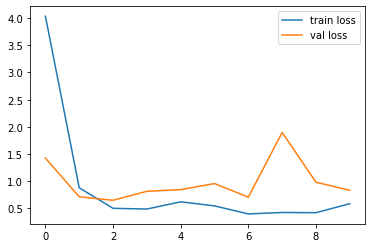

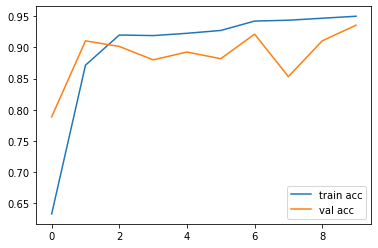

<Figure size 432x288 with 0 Axes>

In [23]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [24]:
# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('/content/drive/MyDrive/nasnet/model_nasnet.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [25]:
y_pred = model.predict(test_set)
y_pred

array([[7.3316565e-25, 3.4549066e-23, 1.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 2.6813476e-32],
       [1.6074803e-20, 1.0851822e-17, 1.0000000e+00, ..., 0.0000000e+00,
        5.9065386e-34, 2.1603188e-23],
       [6.3916417e-24, 1.0000000e+00, 1.1754725e-31, ..., 0.0000000e+00,
        0.0000000e+00, 3.7189218e-24],
       ...,
       [1.1891776e-18, 9.4179960e-30, 1.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 3.1109257e-26],
       [4.0143188e-12, 6.5363042e-06, 9.9997926e-01, ..., 1.4198336e-05,
        3.3935167e-19, 5.3201649e-13],
       [1.3747643e-09, 1.0000000e+00, 1.4309516e-18, ..., 1.4252452e-29,
        2.0456499e-26, 8.1342195e-17]], dtype=float32)

In [26]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([ 2,  2,  1,  2,  3,  0,  2, 16, 10, 12,  9, 14,  2,  3, 14,  0, 17,
       18,  2,  2, 15,  4,  6, 12, 14, 12, 10, 17, 17, 15,  0,  7, 17, 14,
       10,  1, 13,  4, 15,  6, 17, 16,  9,  9,  3,  8,  1, 17,  5,  4, 18,
       16,  0, 10,  5,  0,  0,  5,  1, 13, 13,  1,  6, 18, 10,  1,  4, 15,
        4, 10,  8,  1, 11, 18, 14,  5,  3,  1,  2,  8, 15, 12, 13,  5, 12,
        3, 13,  9,  9, 13, 15, 16, 16,  9, 18,  4,  3,  7,  3,  0,  4,  8,
       16, 12,  1,  9, 16, 14, 12, 13, 16,  4,  6,  2, 17,  4, 11,  4, 11,
       17,  2,  7,  4, 10,  7, 16, 16, 16, 18,  6,  1, 18, 10, 10,  1, 12,
       16,  8, 17, 14, 13, 17, 18,  5,  9,  9,  9, 15,  1,  2, 11, 15, 12,
       12, 15,  6,  1, 14,  9,  2, 10, 15,  8, 17,  1,  2, 10, 18, 16, 17,
        7, 17, 14,  0,  2,  8, 14, 10,  2,  1, 18,  2, 15,  6, 16, 14, 13,
        5, 14, 16,  8,  0, 14, 17, 17, 13,  2,  4, 18, 15,  6,  0, 12,  1,
       16, 15, 10,  1,  3,  9, 14,  4, 14,  0,  7, 15,  1,  5, 17, 11, 16,
        9, 16, 11, 15,  8

In [29]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
model=load_model('/content/drive/MyDrive/nasnet/model_nasnet.h5')

In [30]:
img=image.load_img('/content/drive/MyDrive/nasnet/val/Apple___Cedar_apple_rust/0cd24b0c-0a9d-483f-8734-5c08988e029f___FREC_C.Rust 3762.JPG',target_size=(224,224))

In [31]:
img.info

{'jfif': 257, 'jfif_density': (1, 1), 'jfif_unit': 0, 'jfif_version': (1, 1)}

In [32]:
x=image.img_to_array(img)
x

array([[[125., 119., 121.],
        [127., 121., 123.],
        [128., 122., 124.],
        ...,
        [195., 191., 192.],
        [194., 190., 191.],
        [193., 189., 190.]],

       [[120., 114., 116.],
        [122., 116., 118.],
        [125., 119., 121.],
        ...,
        [188., 184., 185.],
        [188., 184., 185.],
        [187., 183., 184.]],

       [[124., 118., 120.],
        [123., 117., 119.],
        [122., 116., 118.],
        ...,
        [190., 186., 187.],
        [190., 186., 187.],
        [189., 185., 186.]],

       ...,

       [[190., 180., 178.],
        [192., 182., 180.],
        [191., 181., 179.],
        ...,
        [159., 154., 148.],
        [159., 154., 148.],
        [159., 154., 148.]],

       [[191., 181., 179.],
        [190., 180., 178.],
        [188., 178., 176.],
        ...,
        [160., 155., 149.],
        [161., 156., 150.],
        [162., 157., 151.]],

       [[179., 169., 167.],
        [178., 168., 166.],
        [181., 1

In [33]:
x.shape

(224, 224, 3)

In [34]:
x=x/255
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [35]:
model.predict(img_data)

array([[1.22107457e-13, 5.61093652e-13, 2.07154002e-07, 5.05002568e-14,
        9.33995242e-11, 3.26639391e-03, 1.81002370e-12, 6.68778783e-04,
        2.00268351e-17, 8.01436619e-20, 1.01527216e-14, 2.31892637e-20,
        5.96526447e-16, 5.67139380e-17, 3.22363108e-10, 8.34896596e-11,
        9.96059954e-01, 1.97086005e-17, 4.66531628e-06]], dtype=float32)

In [36]:
a=np.argmax(model.predict(img_data), axis=1)

In [37]:
a==1

array([False])

In [38]:
a==18

array([False])

In [39]:
a==17

array([False])

In [40]:
a==0

array([False])

In [41]:
a==14

array([False])

In [42]:
a

array([16])